# Predicción de Series Temporales con Redes Neuronales

El artículo completo con la explicación detallada en el blog: http://www.aprendemachinelearning.com/

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

### Cargamos nuestro Dataset

In [7]:
df = pd.read_csv('time_series.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
df.head()

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

In [8]:
df.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

In [9]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


In [10]:
print(len(df['2017']))
print(len(df['2018']))

315
289


In [11]:
meses =df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

## Visualizaciones

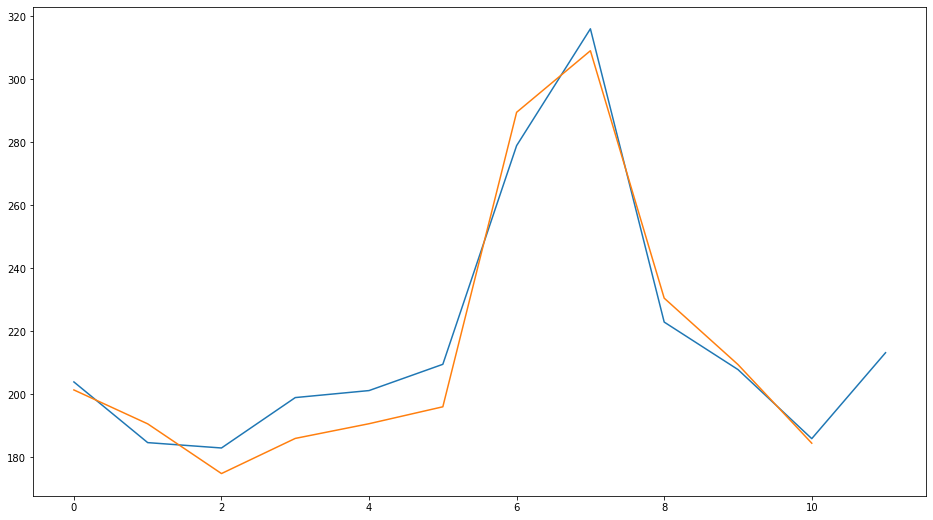

In [12]:
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)

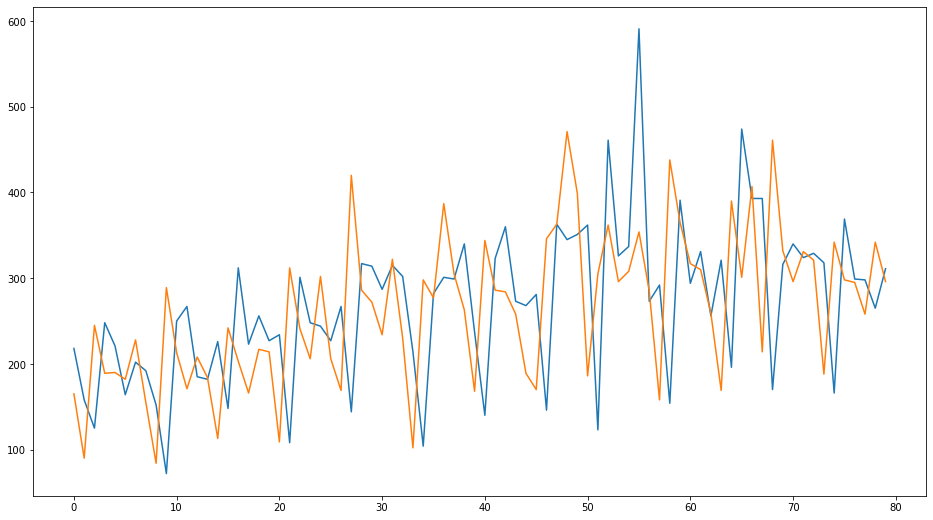

In [13]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

# Preprocesado de los datos

In [14]:
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


## Dividimos en set de Entrenamiento y Validación

In [15]:
# split into train and test sets
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


# Creamos el Modelo de Red Neuronal

## Utilizaremos una Red "normal" Feedforward

In [16]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model


## Entrenamos nuestra máquina

In [17]:
EPOCHS=40

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
81/81 [==============================] - 2s 22ms/step - loss: 0.4347 - mse: 0.2691 - val_loss: 0.2123 - val_mse: 0.0848
Epoch 2/40
81/81 [==============================] - 0s 1ms/step - loss: 0.2449 - mse: 0.0954 - val_loss: 0.2014 - val_mse: 0.0781
Epoch 3/40
81/81 [==============================] - 0s 1ms/step - loss: 0.2289 - mse: 0.0904 - val_loss: 0.1978 - val_mse: 0.0741

## Visualizamos Resultados

In [18]:
history.history

{'loss': [0.35191643238067627,
  0.23701894283294678,
  0.22698721289634705,
  0.21832838654518127,
  0.20995284616947174,
  0.20373569428920746,
  0.19724158942699432,
  0.19215251505374908,
  0.18838977813720703,
  0.1855507344007492,
  0.1828756332397461,
  0.17970475554466248,
  0.17775292694568634,
  0.17616042494773865,
  0.17493613064289093,
  0.17357870936393738,
  0.17335915565490723,
  0.1715744286775589,
  0.1707099974155426,
  0.1705857813358307,
  0.1703110933303833,
  0.1696624457836151,
  0.16984310746192932,
  0.16984042525291443,
  0.16941559314727783,
  0.16876915097236633,
  0.16904325783252716,
  0.17024634778499603,
  0.16909602284431458,
  0.16859428584575653,
  0.16913673281669617,
  0.16962459683418274,
  0.16905061900615692,
  0.1692749410867691,
  0.16928061842918396,
  0.168282613158226,
  0.16828441619873047,
  0.16930972039699554,
  0.16821816563606262,
  0.16853198409080505],
 'mse': [0.19083631038665771,
  0.091822549700737,
  0.08573312312364578,
  0.080

30


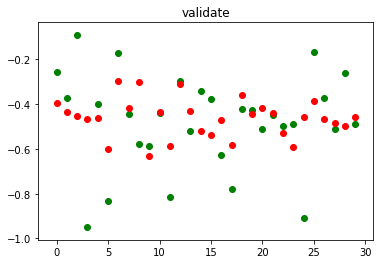

In [14]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()


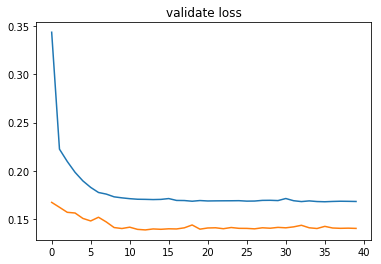

In [15]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

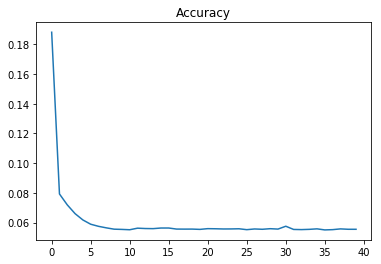

In [16]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [17]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

(30, 1, 7)
(30,)
30


,real,prediccion,diferencia
0,252.000000,214.163651,37.836349
1,220.000000,203.868866,16.131134
2,296.000000,198.812180,97.187820
3,64.999992,194.746170,-129.746185
4,213.000000,196.406677,16.593323


In [18]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633331,196.321518,-4.688193
std,57.580818,23.251623,51.338474
min,64.999992,150.876389,-129.746185
25%,169.000000,182.479301,-24.522148
50%,200.500000,197.162064,1.159111
75%,220.000000,207.022148,26.922920
max,296.000000,241.253464,97.187820


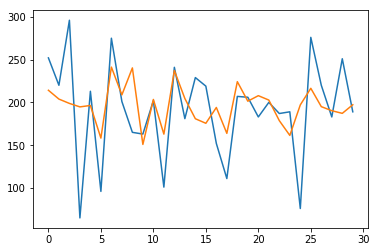

In [19]:
compara2['real'].plot()
compara2['prediccion'].plot()

# Predicción

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [30]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

## Preparamos los datos para Test

In [31]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


In [32]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

In [23]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

## Pronóstico para la "próxima semana"

In [24]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
    

[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75       -0.01510962]]]
[[[-1.          1.          0.44000006  0.06999993  0.75
   -0.01510962 -0.3473066 ]]]
[[[ 1.          0.44000006  0.06999993  0.75       -0.01510962
   -0.3473066   0.4949292 ]]]
[[[ 0.44000006  0.06999993  0.75       -0.01510962 -0.3473066
    0.4949292   0.2773262 ]]]
[[[ 0.06999993  0.75       -0.01510962 -0.3473066   0.4949292
    0.2773262   0.01309414]]]
[[[ 0.75       -0.01510962 -0.3473066   0.4949292   0.2773262
    0.01309414  0.32155222]]]


## Re-Convertimos los resultados

In [33]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.01510962], dtype=float32), array([-0.3473066], dtype=float32), array([0.4949292], dtype=float32), array([0.2773262], dtype=float32), array([0.01309414], dtype=float32), array([0.32155222], dtype=float32), array([-0.00763017], dtype=float32)]


array([[174.48904094],
       [141.26934129],
       [225.49292353],
       [203.73262324],
       [177.30941712],
       [208.1552254 ],
       [175.23698644]])

## Visualizamos el pronóstico

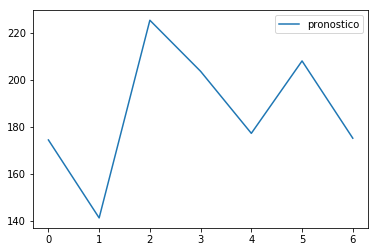

In [35]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

In [27]:
prediccion1SemanaDiciembre

,pronostico
0,174.489041
1,141.269341
2,225.492924
3,203.732623
4,177.309417
5,208.155225
6,175.236986


# Agregamos el resultado en el dataset

In [28]:
i=0
for fila in prediccion1SemanaDiciembre.pronostico:
    i=i+1
    ultimosDias.loc['2018-12-0' + str(i) + ' 00:00:00'] = fila
    print(fila)
ultimosDias.tail(14)

174.48904094075502
141.26934128856678
225.49292353152313
203.73262324331603
177.30941712430308
208.15522539962586
175.23698644310952


fecha
2018-11-24 00:00:00    189.000000
2018-11-25 00:00:00     76.000000
2018-11-26 00:00:00    276.000000
2018-11-27 00:00:00    220.000000
2018-11-28 00:00:00    183.000000
2018-11-29 00:00:00    251.000000
2018-11-30 00:00:00    189.000000
2018-12-01 00:00:00    174.489041
2018-12-02 00:00:00    141.269341
2018-12-03 00:00:00    225.492924
2018-12-04 00:00:00    203.732623
2018-12-05 00:00:00    177.309417
2018-12-06 00:00:00    208.155225
2018-12-07 00:00:00    175.236986
Name: unidades, dtype: float64

El artículo completo en www.aprendemachinelearning.com